# On similarity measures for image registration
_María Camila Vásquez Correa_

## Necessary Packages

In [1]:
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import nibabel as nib
import skimage
from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
warnings.filterwarnings("ignore")

In [2]:
# Plot parameters
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
# Data loading
t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_data()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_data()

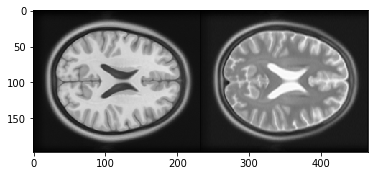

In [4]:
# Slice of the Nifti image
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
plt.imshow(np.hstack((t1_slice, t2_slice)))
plt.show()

Text(0.5, 1.0, 'T2 slice histogram')

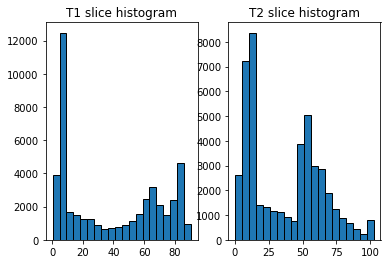

In [5]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(t1_slice.ravel(), bins=20)
axes[0].set_title('T1 slice histogram')
axes[1].hist(t2_slice.ravel(), bins=20)
axes[1].set_title('T2 slice histogram')
plt.show()

0.7870798551095302

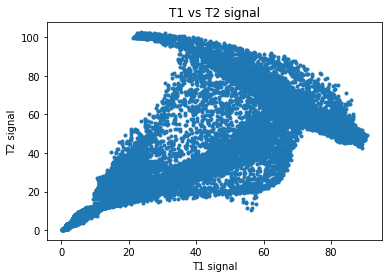

In [6]:
plt.plot(t1_slice.ravel(), t2_slice.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 signal')
plt.title('T1 vs T2 signal')
np.corrcoef(t1_slice.ravel(), t2_slice.ravel())[0, 1]

Text(0.5, 1.0, 'T2 slice')

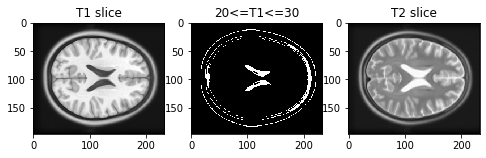

In [7]:
# Array that is True if T1 signal >= 20, <= 30, False otherwise
t1_20_30 = (t1_slice >= 20) & (t1_slice <= 30)
# Show T1 slice, mask for T1 between 20 and 30, T2 slice
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(t1_slice)
axes[0].set_title('T1 slice')
axes[1].imshow(t1_20_30)
axes[1].set_title('20<=T1<=30')
axes[2].imshow(t2_slice)
axes[2].set_title('T2 slice')

In [8]:
hist_2d, x_edges, y_edges = np.histogram2d(
    t1_slice.ravel(),
    t2_slice.ravel(),
    bins=20)

Text(0, 0.5, 'T2 signal bin')

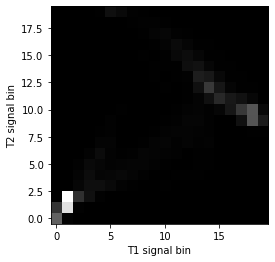

In [9]:
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')
plt.show()

Text(0, 0.5, 'T2 signal bin')

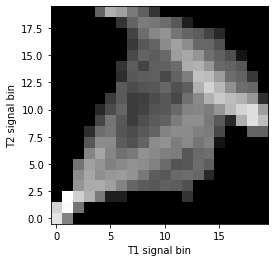

In [10]:
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

## Mutual information

In [11]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

mutual_information(hist_2d)

1.3399511058289812

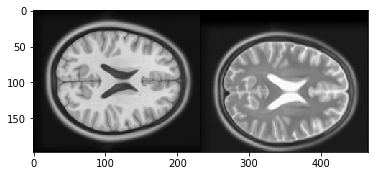

In [12]:
t2_slice_moved = np.zeros(t2_slice.shape)
t2_slice_moved[15:, :] = t2_slice[:-15, :]
plt.imshow(np.hstack((t1_slice, t2_slice_moved)))
plt.show()


Text(0.5, 1.0, 'T1 vs T2 signal after moving T2 image')

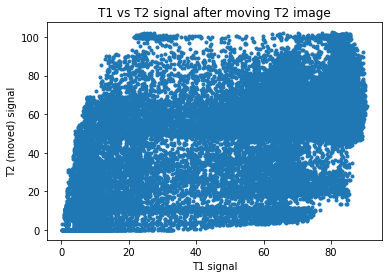

In [13]:
plt.plot(t1_slice.ravel(), t2_slice_moved.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 (moved) signal')
plt.title('T1 vs T2 signal after moving T2 image')


In [14]:
hist_2d_moved, x_edges, y_edges = np.histogram2d(
    t1_slice.ravel(),
    t2_slice_moved.ravel(),
    bins=20)

Text(0, 0.5, 'T2 signal bin')

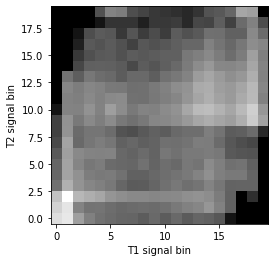

In [15]:
hist_2d_moved_log = np.zeros(hist_2d_moved.shape)
non_zeros = hist_2d_moved != 0
hist_2d_moved_log[non_zeros] = np.log(hist_2d_moved[non_zeros])
plt.imshow(hist_2d_moved_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')
plt.show()

In [16]:
mutual_information(hist_2d_moved)

0.4577827377824529

## Shannon Joint Entropy

In [18]:
entropy_T1 = skimage.measure.shannon_entropy(t1_slice)
entropy_T2 = skimage.measure.shannon_entropy(t2_slice)
joint_entropy = entropy_T1 + entropy_T2 - mutual_information(hist_2d)

In [19]:
joint_entropy

26.9976311949709

## Sum of squared differences

In [20]:
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

In [21]:
mse(t1_slice, t2_slice)

376.9846047746162

## Correlation coefficient

In [22]:
def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

In [23]:
correlation_coefficient(t1_slice, t2_slice)

0.7870798551095303

## Correlation ratio

In [24]:
# Flat the vector
t1 = t1_slice.flatten()
t2 = t2_slice.flatten()

In [25]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

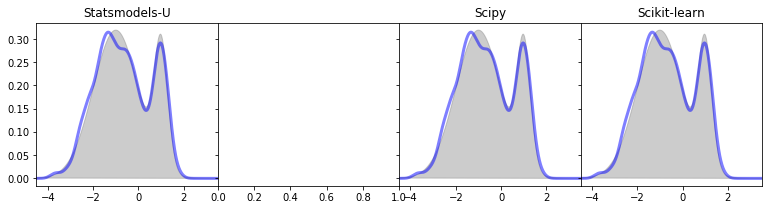

In [26]:
# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    try:
        pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
        ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
        ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
        ax[i].set_title(kde_funcnames[i])
        ax[i].set_xlim(-4.5, 3.5)
    except:
        continue
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")

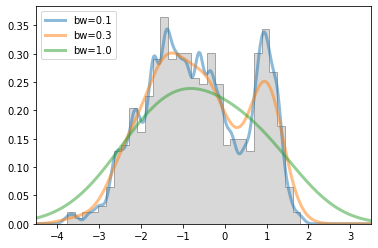

In [27]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(-4.5, 3.5)
ax.legend(loc='upper left')
plt.show()

In [28]:
dens_u = KDEMultivariate(data=[t1,t2],
                         var_type='cc', bw='normal_reference')

In [29]:
a = [1,2,3]
b = zip(t1,[100]*len(t1))

In [28]:
kde = KernelDensity(kernel='epanechnikov', algorithm='ball_tree',bandwidth=0.2).fit(np.array([t1,t2]).transpose())

In [29]:
def conditional_variance(dens, marginal, X, y):
    # dens is the probability density funciton of the vectors X and Y
    # X is the support of the variable X
    # y is the fixed value for the Y variable
    # marginal is PY(y)
    py = marginal.evaluate(y)
    joint = np.array(list(map(list,zip(X,[y]*len(X)))))
    joint_prob = np.exp(dens.score_samples(joint))
    left = X**2*joint_prob.transpose()/py
    #left = np.array([x**2*dens.pdf([x,y])/marginal.evaluate(y) for x in X])
    left = np.sum(left)
    #right = np.array([x*dens.pdf([x,y])/marginal.evaluate(y) for x in X])
    right = X*joint_prob.transpose()/py
    right = np.sum(right)**2
    #print(sum(joint_prob.transpose()/py))
    #print(left,right)
    return left - right

In [30]:
# Distribuciones marginales
marginalY = KDEUnivariate(t2)
marginalY.fit()
marginalX = KDEUnivariate(t1)
marginalX.fit()

In [33]:
joint = list(map(list,zip(t1,[t2[0]]*len(t1))))
np.array(joint).shape
aa = np.exp(kde.score_samples(joint))
bb = t1**2*aa.transpose()
a1 = np.array([x**2*(np.exp(kde.score_samples(np.array([x,t2[0]]).reshape(1,-1)))) for x in t1])

In [34]:
conditional_variance(kde, marginalY, t1, t2[0])

-2.0299060643022298

In [35]:
#sum(np.exp(kde.score_samples(np.array([t1,t2]).transpose())))
print(t1.min(),t1.max())
t2.min(),t2.max()
#kde.score_samples(np.array([t1,t2]).transpose())

0.3043467696988955 90.55689174856525


(0.19431926915422082, 102.50326587958261)

In [31]:
def corr(X, Y, dens, marginalY):
    var = np.var(X)
    su = [conditional_variance(dens,marginalY,X,y)*marginalY.evaluate(y) for y in Y]
    su = np.sum(su)
    return su/var

In [32]:
def correlation_ratio(X,Y,dens, marginalY, marginalX):
    left = corr(X,Y,dens,marginalY)
    right = corr(Y,X,dens,marginalX)
    return left + right

In [33]:
import pandas as pd
pd.Series(t2).describe()

count    45901.000000
mean        36.484117
std         26.728647
min          0.194319
25%         10.598048
50%         34.658575
75%         57.293781
max        102.503266
dtype: float64

In [202]:
correlation_ratio(t1,t2,kde, marginalY,marginalX)

3.416379584503374
0.9655851160296377 2.9954911803318676
114.88760486890087
46.130336595340665 5138.341590345649
220.14953421794718
114.44826983478245 22715.097542314303
191.9105354230209
90.22087407001834 16046.829941991737
136.80400889025597
56.833151983720704 7464.630928763777
124.82029269432898
50.70943052041441 6119.114804200891
238.86381928849192
140.0790583087614 29273.18933865297
190.14475415532215
88.92738592432443 15694.580778349758
132.78495279710495
54.72207022815965 6993.76710261623
146.84534927830686
62.30617254581065 8727.49730225786
231.828493402313
129.3679478722433 26547.236312514015
162.44223277439403
71.24541583071483 10935.326387546549
175.57050382221746
79.08313383162485 13025.614258580978
251.13834064758146
162.36582181012784 34966.52920313053
230.38206577192813
127.31299992889178 26025.609767391587
230.38206577192813
127.31299992889178 26025.609767391587
268.5291208889227
210.54501948168172 47108.652437141456
266.7213819695167
203.63310426147763 45392.83405211702

KeyboardInterrupt: 

In [39]:
def compression(x):
    # x a matrix of nxm
    n,m = x.size()
    

In [34]:
import scipy.integrate as integrate

In [35]:
def left_cond_var(x,y,marginaly,dens):
    a = np.exp(dens.score_samples(np.array([x,y]).reshape(1,-1)))
    return x**2*a/marginaly    

In [36]:
def right_cond_var(x,y,marginaly,dens):
    a = np.exp(dens.score_samples(np.array([x,y]).reshape(1,-1)))
    return x*a/marginaly 

In [37]:
integrate.quad(lambda x: left_cond_var(x,t2[0],marginalY.evaluate(t2[0]),kde),min(t1),max(t1))

(0.0061260980945914804, 5.090679414208182e-07)

In [38]:
def cond_var(X,y,marginalY,dens):
    left = integrate.quad(lambda x: left_cond_var(x,y,marginalY.evaluate(y),dens),min(X),max(X))[0]
    right = integrate.quad(lambda x: right_cond_var(x,y,marginalY.evaluate(y),dens),min(X),max(X))[0]
    return left - right**2

In [39]:
cond_var(t1,t2[0],marginalY,kde)

0.005955857119215773

In [45]:
def corr_ratio(X,y,marginalY,dens):
    a = cond_var(X,y,marginalY,dens)*marginalY.evaluate(y)
    if a < 0:
        print(y, "Santiago Cosota")
    return a

In [41]:
corr_ratio(t1,t2[0],marginalY,kde)

array([3.46324607e-05])

In [42]:
def corr(X, Y, dens, marginalY):
    var = np.var(X)
    su = integrate.quad(lambda y: corr_ratio(X,y,marginalY,dens), min(Y),max(Y))[0]
    return su/var

In [43]:
def correlation_ratio(X,Y,dens, marginalY, marginalX):
    left = corr(X,Y,dens,marginalY)
    right = corr(Y,X,dens,marginalX)
    return left + right

In [46]:
correlation_ratio(t1,t2,kde, marginalY,marginalX)

51.34879257436842 Santiago Cosota
1.5291170595629282 Santiago Cosota
101.1684680891739 Santiago Cosota
80.13633739709239 Santiago Cosota
50.68139367916406 Santiago Cosota
21.963761722127686 Santiago Cosota
29.579350121394953 Santiago Cosota
51.23771480533582 Santiago Cosota
49.56241420236161 Santiago Cosota
11.377783510399334 Santiago Cosota
52.016191469572775 Santiago Cosota
54.80009877767033 Santiago Cosota
80.73382342660915 Santiago Cosota
51.459870343401015 Santiago Cosota
53.135170946375226 Santiago Cosota
100.7168875075758 Santiago Cosota
64.13741090067197 Santiago Cosota
51.682492021970596 Santiago Cosota
53.07444567601937 Santiago Cosota
55.448701244457084 Santiago Cosota
62.23351380085515 Santiago Cosota
66.04130800048878 Santiago Cosota
51.40433145888471 Santiago Cosota
52.24198176037182 Santiago Cosota
76.0328400409721 Santiago Cosota
54.15183101294624 Santiago Cosota
67.90228885974882 Santiago Cosota
100.77761277793167 Santiago Cosota
81.02593789706418 Santiago Cosota
84.17

KeyboardInterrupt: 

## Sliding window

In [34]:
# Parameters
alpha = 4 # size of the window, integer
def d(a,b): # distance measure
    pass
